A slightly class-ier version.  Hopefully this'll be the last 'generation' of notebook for this.  Anyone who's good at Python code reviews please follow along and give feedback :)

The plan is to document things *a lot* better as I go along and put things in a nice OO (and closer to PEP8) style.  (This generally hasn't been met yet)

None of the above has really happened yet. ;)

-r3 implemented PAL - including rough audio support.

In [1]:
from base64 import b64encode
import copy
from datetime import datetime
import getopt
import io
from io import BytesIO
import os
import sys

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(20, 12))

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

#internal libraries which may or may not get used
import fdls
from lddutils import *

In [2]:
# Notebook-only functions go here

# Draws a uint16 image, downscaled to uint8
def draw_raw_bwimage(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())



In [3]:
def calclinelen(SP, mult, mhz):
    if type(mhz) == str:
        mhz = SP[mhz]
        
    return int(np.round(SP['line_period'] * mhz * mult)) 

# These are invariant parameters 
SysParams_NTSC = {
    'fsc_mhz': (315.0 / 88.0),
    'pilot_mhz': (315.0 / 88.0),
    'frame_lines': 525,

    'ire0': 8100000,
    'hz_ire': 1700000 / 140.0,

    # most NTSC disks have analog audio, except CD-V and a few Panasonic demos
    'analog_audio': True,
    # From the spec - audio frequencies are multiples of the (color) line rate
    'audio_lfreq': (1000000*315/88/227.5) * 146.25,
    'audio_rfreq': (1000000*315/88/227.5) * 178.75,
    
    'philips_codelines': [16, 17, 18]
}

# In color NTSC, the line period was changed from 63.5 to 227.5 color cycles,
# which works out to 63.5(with a bar on top) usec
SysParams_NTSC['line_period'] = 1/(SysParams_NTSC['fsc_mhz']/227.5)
SysParams_NTSC['FPS'] = 1000000/ (525 * SysParams_NTSC['line_period'])

SysParams_NTSC['outlinelen'] = calclinelen(SysParams_NTSC, 4, 'fsc_mhz')

SysParams_PAL = {
    'FPS': 25,
    
    'fsc_mhz': ((1/64) * 283.75) + (25/1000000),
    'pilot_mhz': 3.75,
    'frame_lines': 625,
    'line_period': 64,

    'ire0': 7100000,
    'hz_ire': 800000 / 100.0,

    # only early PAL disks have analog audio
    'analog_audio': True,
    # From the spec - audio frequencies are multiples of the (color) line rate
    'audio_lfreq': (1000000/64) * 43.75,
    'audio_rfreq': (1000000/64) * 68.25,

    'philips_codelines': [19, 20, 21]
}

SysParams_PAL['outlinelen'] = calclinelen(SysParams_PAL, 4, 'fsc_mhz')
SysParams_PAL['outlinelen_pilot'] = calclinelen(SysParams_PAL, 4, 'pilot_mhz')


SysParams_PAL['vsync_ire'] = .3 * (100 / .7)

RFParams_NTSC = {
    # The audio notch filters are important with DD v3.0+ boards
    'audio_notchwidth': 350000,
    'audio_notchorder': 2,

    # (note:  i don't know how to handle these values perfectly yet!)
    'video_deemp': (120*.32, 320*.32), # On some captures this is as low as .55.

    # This BPF is similar but not *quite* identical to what Pioneer did
    'video_bpf': [3500000, 13200000],
    'video_bpf_order': 3,

    # This can easily be pushed up to 4.5mhz or even a bit higher. 
    # A sharp 4.8-5.0 is probably the maximum before the audio carriers bleed into 0IRE.
    'video_lpf_freq': 4200000,   # in mhz
    'video_lpf_order': 5 # butterworth filter order
}

RFParams_PAL = {
    # The audio notch filters are important with DD v3.0+ boards
    'audio_notchwidth': 200000,
    'audio_notchorder': 2,

    'video_deemp': (100*.32, 400*.32),

    # XXX: guessing here!
    'video_bpf': (2600000, 12500000),
    'video_bpf_order': 3,

    'video_lpf_freq': 4800000,
    'video_lpf_order': 5,
    
}

In [4]:
class RFDecode:
    def __init__(self, inputfreq = 40, system = 'NTSC', blocklen_ = 16384, analog_audio = True):
        self.blocklen = blocklen_
        self.blockcut = 1024 # ???
        self.system = system
        
        freq = inputfreq
        self.freq = freq
        self.freq_half = freq / 2
        self.freq_hz = self.freq * 1000000
        self.freq_hz_half = self.freq * 1000000 / 2
        
        if system == 'NTSC':
            self.SysParams = SysParams_NTSC
            self.DecoderParams = RFParams_NTSC
            
            self.Filters = {
                'MTF': sps.zpk2tf([], [polar2z(.7,np.pi*12.5/20), polar2z(.7,np.pi*27.5/20)], 1.11)
            }
        elif system == 'PAL':
            self.SysParams = SysParams_PAL
            self.DecoderParams = RFParams_PAL
            
            self.Filters = {
                'MTF': sps.zpk2tf([], [polar2z(.7,np.pi*10/20), polar2z(.7,np.pi*28/20)], 1.11)
            }

        linelen = self.freq_hz/(1000000.0/self.SysParams['line_period'])
        self.linelen = int(np.round(linelen))
            
        self.analog_audio = analog_audio
            
        self.computevideofilters()
        if self.analog_audio: 
            self.computeaudiofilters()
            
    def computevideofilters(self):
        self.Filters = {}
        
        # Use some shorthand to compact the code.  good idea?  prolly not.
        SF = self.Filters
        SP = self.SysParams
        DP = self.DecoderParams
        
        SF['hilbert'] = np.fft.fft(hilbert_filter, self.blocklen)
        
        filt_rfvideo = sps.butter(DP['video_bpf_order'], [DP['video_bpf'][0]/self.freq_hz_half, DP['video_bpf'][1]/self.freq_hz_half], btype='bandpass')
        SF['RFVideo'] = filtfft(filt_rfvideo, self.blocklen)

        if SP['analog_audio']: 
            cut_left = sps.butter(DP['audio_notchorder'], [(SP['audio_lfreq'] - DP['audio_notchwidth'])/self.freq_hz_half, (SP['audio_lfreq'] + DP['audio_notchwidth'])/self.freq_hz_half], btype='bandstop')
            SF['Fcutl'] = filtfft(cut_left, self.blocklen)
            cut_right = sps.butter(DP['audio_notchorder'], [(SP['audio_rfreq'] - DP['audio_notchwidth'])/self.freq_hz_half, (SP['audio_rfreq'] + DP['audio_notchwidth'])/self.freq_hz_half], btype='bandstop')
            SF['Fcutr'] = filtfft(cut_right, self.blocklen)
        
            SF['RFVideo'] *= (SF['Fcutl'] * SF['Fcutr'])
            
        SF['RFVideo'] *= SF['hilbert']
        
        video_lpf = sps.butter(DP['video_lpf_order'], DP['video_lpf_freq']/self.freq_hz_half, 'low')
        SF['Fvideo_lpf'] = filtfft(video_lpf, self.blocklen)

        # The deemphasis filter.  This math is probably still quite wrong, but with the right values it works
        deemp0, deemp1 = DP['video_deemp']
        [tf_b, tf_a] = sps.zpk2tf(-deemp1*(10**-10), -deemp0*(10**-10), deemp0 / deemp1)
        SF['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/self.freq_hz_half), self.blocklen)

        # The direct opposite of the above, used in test signal generation
        [tf_b, tf_a] = sps.zpk2tf(-deemp0*(10**-10), -deemp1*(10**-10), deemp1 / deemp0)
        SF['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/self.freq_hz_half), self.blocklen)
        
        # Post processing:  lowpass filter + deemp
        SF['FVideo'] = SF['Fvideo_lpf'] * SF['Fdeemp'] 
    
        # additional filters:  0.5mhz and color burst
        # Using an FIR filter here to get tighter alignment
        F0_5 = sps.firwin(65, [0.5/self.freq_half], pass_zero=True)
        SF['F0_5'] = filtfft((F0_5, [1.0]), self.blocklen)
        SF['FVideo05'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['F0_5']

        SF['Fburst'] = filtfft(sps.butter(1, [(SP['fsc_mhz']-.1)/self.freq_half, (SP['fsc_mhz']+.1)/self.freq_half], btype='bandpass'), self.blocklen) 
        SF['FVideoBurst'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['Fburst']

        if self.system == 'PAL':
            SF['Fpilot'] = filtfft(sps.butter(1, [3.7/self.freq_half, 3.8/self.freq_half], btype='bandpass'), self.blocklen) 
            SF['FVideoPilot'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['Fpilot']
        
        # emperical work determined that a single-pole low frequency filter effectively 
        # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
        f = sps.butter(1, 0.05/self.freq_half, btype='low')
        SF['FPsync'] = filtfft(f, self.blocklen)

    # frequency domain slicers.  first and second stages use different ones...
    def audio_fdslice(self, freqdomain):
        return np.concatenate([freqdomain[self.Filters['audio_fdslice_lo']], freqdomain[self.Filters['audio_fdslice_hi']]])

    def audio_fdslice2(self, freqdomain):
        return np.concatenate([freqdomain[self.Filters['audio_fdslice2_lo']], freqdomain[self.Filters['audio_fdslice2_hi']]])
    
    def computeaudiofilters(self):
        SF = self.Filters
        SP = self.SysParams
        DP = self.DecoderParams

        # first stage audio filters
        if self.freq >= 32:
            audio_fdiv1 = 32 # this is good for 40mhz - 16 should be ideal for 28mhz
        else:
            audio_fdiv1 = 16
            
        SF['audio_fdiv1'] = audio_fdiv1
            
        afft_halfwidth = self.blocklen // (audio_fdiv1 * 2)
        arf_freq = self.freq_hz / (audio_fdiv1 / 2)
        SF['freq_arf'] = arf_freq
        SF['audio_fdiv1'] = audio_fdiv1

        SP['audio_cfreq'] = (SP['audio_rfreq'] + SP['audio_lfreq']) // 2
        afft_center = int((SP['audio_cfreq'] / self.freq_hz) * (self.blocklen))

        # beginning and end symmetrical frequency domain slices.  combine to make a cut-down sampling
        afft_start = int(afft_center-afft_halfwidth)
        afft_end = int(afft_center+afft_halfwidth)

        # slice areas for reduced FFT audio demodulation filters
        SF['audio_fdslice_lo'] = slice(afft_start, afft_end)
        SF['audio_fdslice_hi'] = slice(self.blocklen-afft_end, self.blocklen-afft_start)

        # compute the base frequency of the cut audio range
        SF['audio_lowfreq'] = SP['audio_cfreq']-(self.freq_hz/(2*SF['audio_fdiv1']))

        apass = 150000 # audio RF bandpass.  150khz is the maximum transient.
        afilt_len = 800 # good for 150khz apass

        afilt_left = filtfft([sps.firwin(afilt_len, [(SP['audio_lfreq']-apass)/self.freq_hz_half, (SP['audio_lfreq']+apass)/self.freq_hz_half], pass_zero=False), 1.0], self.blocklen)
        SF['audio_lfilt'] = self.audio_fdslice(afilt_left * SF['hilbert']) 
        afilt_right = filtfft([sps.firwin(afilt_len, [(SP['audio_rfreq']-apass)/self.freq_hz_half, (SP['audio_rfreq']+apass)/self.freq_hz_half], pass_zero=False), 1.0], self.blocklen)
        SF['audio_rfilt'] = self.audio_fdslice(afilt_right * SF['hilbert'])

        # second stage audio filters (decimates further, and applies audio LPF)
        audio_fdiv2 = 4
        SF['audio_fdiv2'] = audio_fdiv2
        SF['audio_fdiv'] = audio_fdiv1 * audio_fdiv2
        SF['freq_aud2'] = SF['freq_arf'] / audio_fdiv2

        # slice areas for reduced FFT audio filters
        SF['audio_fdslice2_lo'] = slice(0, self.blocklen//(audio_fdiv2*2))
        SF['audio_fdslice2_hi'] = slice(self.blocklen-self.blocklen//(audio_fdiv2*2), self.blocklen)

        SF['audio_lpf2'] = filtfft([sps.firwin(65, [21000/(SF['freq_aud2']/2)]), [1.0]], self.blocklen // SF['audio_fdiv2'])

        # convert 75usec into the exact -3dB frequency
        d75freq = 1000000/(2*pi*75)

        # I was overthinking deemphasis for a while.  For audio it turns out a straight
        # 1-pole butterworth does a good job.
        adeemp_b, adeemp_a = sps.butter(1, [d75freq/(SF['freq_aud2']/2)], btype='lowpass')
        SF['audio_deemp2'] = filtfft([adeemp_b, adeemp_a],  self.blocklen // SF['audio_fdiv2'])
        
        
    def iretohz(self, ire):
        return self.SysParams['ire0'] + (self.SysParams['hz_ire'] * ire)

    def hztoire(self, hz):
        return (hz - self.SysParams['ire0']) / self.SysParams['hz_ire']
    
    def demodblock(self, data, mtf_level = 0):
        indata_fft = np.fft.fft(data[:self.blocklen])
        indata_fft_filt = indata_fft * self.Filters['RFVideo']

        if mtf_level != 0:
            indata_fft_filt *= self.Filters['MTF'] ** mtf_level

        hilbert = np.fft.ifft(indata_fft_filt)
        demod = unwrap_hilbert(hilbert, self.freq_hz)

        demod_fft = np.fft.fft(demod)

        out_video = np.fft.ifft(demod_fft * self.Filters['FVideo']).real
        out_video05 = np.fft.ifft(demod_fft * self.Filters['FVideo05']).real
        out_videoburst = np.fft.ifft(demod_fft * self.Filters['FVideoBurst']).real
        
        # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
        output_sync = inrange(out_video05, self.iretohz(-55), self.iretohz(-25))
        # Perform FFT convolution of above filter
        output_syncf = np.fft.ifft(np.fft.fft(output_sync) * self.Filters['FPsync']).real

        if self.system == 'PAL':
            out_videopilot = np.fft.ifft(demod_fft * self.Filters['FVideoPilot']).real
            rv_video = np.rec.array([out_video, out_video05, output_syncf, out_videoburst, out_videopilot], names=['demod', 'demod_05', 'demod_sync', 'demod_burst', 'demod_pilot'])
        else:
            rv_video = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])

        if self.analog_audio == False:
            return rv_video, None

        # Audio phase 1
        hilbert = np.fft.ifft(self.audio_fdslice(indata_fft) * self.Filters['audio_lfilt'])
        audio_left = unwrap_hilbert(hilbert, self.Filters['freq_arf']) + self.Filters['audio_lowfreq']

        hilbert = np.fft.ifft(self.audio_fdslice(indata_fft) * self.Filters['audio_rfilt'])
        audio_right = unwrap_hilbert(hilbert, self.Filters['freq_arf']) + self.Filters['audio_lowfreq']

        rv_audio = np.rec.array([audio_left, audio_right], names=['audio_left', 'audio_right'])

        return rv_video, rv_audio
    
    # Second phase audio filtering.  This works on a whole field's samples, since 
    # the frequency is reduced by 16/32x.

    def runfilter_audio_phase2(self, frame_audio, start):
        left = frame_audio['audio_left'][start:start+self.blocklen].copy() 
        left_fft = np.fft.fft(left)
        audio_out_fft = self.audio_fdslice2(left_fft) * self.Filters['audio_lpf2']
        left_out = np.fft.ifft(audio_out_fft).real / self.Filters['audio_fdiv2']

        right = frame_audio['audio_right'][start:start+self.blocklen].copy() 
        right_fft = np.fft.fft(right)
        audio_out_fft = self.audio_fdslice2(right_fft) * self.Filters['audio_lpf2'] #* adeemp
        right_out = np.fft.ifft(audio_out_fft).real / self.Filters['audio_fdiv2']

        return np.rec.array([left_out, right_out], names=['audio_left', 'audio_right'])

    def audio_phase2(self, field_audio):
        # this creates an output array with left/right channels.
        output_audio2 = np.zeros(len(field_audio['audio_left']) // self.Filters['audio_fdiv2'], dtype=field_audio.dtype)

        # copy the first block in it's entirety, to keep audio and video samples aligned
        tmp = self.runfilter_audio_phase2(field_audio, 0)
        output_audio2[:tmp.shape[0]] = tmp

        end = field_audio.shape[0] #// filterset['audio_fdiv2']

        askip = 64 # length of filters that needs to be chopped out of the ifft
        sjump = self.blocklen - (askip * self.Filters['audio_fdiv2'])

        ostart = tmp.shape[0]
        for sample in range(sjump, field_audio.shape[0] - sjump, sjump):
            tmp = self.runfilter_audio_phase2(field_audio, sample)
            oend = ostart + tmp.shape[0] - askip
            output_audio2[ostart:oend] = tmp[askip:]
            ostart += tmp.shape[0] - askip

        tmp = self.runfilter_audio_phase2(field_audio, end - self.blocklen - 1)
        output_audio2[output_audio2.shape[0] - (tmp.shape[0] - askip):] = tmp[askip:]

        return output_audio2    

    def demod(self, infile, start, length):
        end = int(start + length) + 1

        if (start > self.blockcut):
            start = int(start - self.blockcut)
        else:
            start = 0 # should this be an error?  prolly.

        # set a placeholder
        output = None
        output_audio = None

        for i in range(start, end, self.blocklen - self.blockcut):
            indata = loader(infile, i, self.blocklen)
            if indata is None:
                break

            tmp_video, tmp_audio = self.demodblock(indata)

            # if the output hasn't been created yet, do it now using the 
            # data types returned by dodemod (should be faster than multiple
            # allocations...)
            if output is None:
                output = np.zeros(end - start + 1, dtype=tmp_video.dtype)

            if i - start + (self.blocklen - self.blockcut) > len(output):
                copylen = len(output) - (i - start)
            else:
                copylen = self.blocklen - self.blockcut

            output_slice = slice(i - start, i - start + copylen)
            tmp_slice = slice(self.blockcut, self.blockcut + copylen)

            output[output_slice] = tmp_video[tmp_slice]

            # repeat the above - but for audio
            if tmp_audio is not None:
                audio_downscale = tmp_video.shape[0] // tmp_audio.shape[0]

                if output_audio is None:
                    output_audio = np.zeros(((end - start) // audio_downscale) + 1, dtype=tmp_audio.dtype)

                output_slice = slice((i - start) // audio_downscale, (i - start + copylen) // audio_downscale)
                tmp_slice = slice(self.blockcut // audio_downscale, (self.blockcut + copylen) // audio_downscale)

                output_audio[output_slice] = tmp_audio[tmp_slice]

        if tmp_audio is not None:
            return output, self.audio_phase2(output_audio)
        else:
            return output, None

In [5]:
# right now defualt is 16/48, so not optimal :)
def downscale_audio(audio, lineinfo, rf, linecount, timeoffset = 0, freq = 48000.0, scale=64):
    frametime = (rf.SysParams['line_period'] * linecount) / 1000000 
    soundgap = 1 / freq

    # include one extra 'tick' to interpolate the last one and use as a return value
    # for the next frame
    arange = np.arange(timeoffset, frametime + soundgap, soundgap, dtype=np.double)
    locs = np.zeros(len(arange), dtype=np.float)
    swow = np.zeros(len(arange), dtype=np.float)
    
    for i, t in enumerate(arange):
        lineloc = ((t * 1000000) / rf.SysParams['line_period']) + 1

        sampleloc = lineinfo[np.int(lineloc)]
        sampleloc += (lineinfo[np.int(lineloc) + 1] - lineinfo[np.int(lineloc)]) * (lineloc - np.floor(lineloc))

        swow[i] = ((lineinfo[int(lineloc) + 1] - lineinfo[int(lineloc)]) / rf.linelen)
        locs[i] = sampleloc / scale
        
        if False:        
            wowratio = 1 - (lineloc - np.floor(lineloc))
            wow = (lineinfo[l + 1] - lineinfo[l]) / rf.linelen
            swow[i] = wow[np.int(lineloc)] * (1 - wowratio)
            swow[i] += wow[np.int(lineloc + 1 )] * (wowratio)

            locs[i] = sampleloc / scale

    output = np.zeros((2 * (len(arange) - 1)), dtype=np.int32)
    output16 = np.zeros((2 * (len(arange) - 1)), dtype=np.int16)

    # use two passes so the next location can be known
    for i in range(len(arange) - 1):    
        # rough linear approx for now
        output_left = audio['audio_left'][np.int(locs[i])]
        output_right = audio['audio_right'][np.int(locs[i])]

        output_left *= swow[i]
        output_right *= swow[i]
        
        output_left -= rf.SysParams['audio_lfreq']
        output_right -= rf.SysParams['audio_rfreq']
        
        output[(i * 2) + 0] = int(np.round(output_left * 32767 / 150000))
        output[(i * 2) + 1] = int(np.round(output_right * 32767 / 150000))
        
    np.clip(output, -32766, 32766, out=output16)
            
    return output16, arange[-1] - frametime

#audb, offset, arange, locs = downscale_audio(fields[0].rawdecode[1], fields[0].linelocs, rfd, 262)

In [119]:
# The Field class contains a common 
class Field:

    def usectoinpx(self, x):
        return x * self.rf.freq
    
    def inpxtousec(self, x):
        return x / self.rf.freq
    
    def get_syncpeaks(self):
        # This is done as a while loop so each peak lookup is aligned to the previous one
        ds = self.data[0]['demod_sync']

        peaklist = []

        i = self.start
        while i < (len(ds) - (self.inlinelen * 2)):
            peakloc = np.argmax(ds[i:i + (self.inlinelen//2)])
            peak = ds[i + peakloc]

            if peak > .2:
                # TODO: validity check for lack of rot goes here?

                # TODO: Work out adjustments for NTSC and PAL automagically
                lineloc = i + peakloc + 0

                peaklist.append(lineloc)

                # This allows all peaks to get caught properly
                i += peakloc + int(self.rf.linelen * .4)
            else: # nothing valid found - keep looking!
                i += self.rf.linelen // 2
                
        return peaklist

    def determine_field(self, peaknum):
        if peaknum < 11:
            return None

        ds = self.data[0]['demod_sync']    

        # Determine first/second field
        # should this rely on what comes *after* the vsync too?
        line0 = None
        for i in range(peaknum - 1, peaknum - 10, -1):
            peak = ds[self.peaklist[i]]
            prevpeak = ds[self.peaklist[i + 1]]

            if peak > .6 and line0 is None:
                line0 = i

        return line0, (self.peaklist[line0 + 1] - self.peaklist[line0]) < (self.inlinelen * .75)     

    def determine_vsyncs(self):
        # find vsyncs from the peaklist
        ds = self.data[0]['demod_sync']
        vsyncs = []

        prevpeak = 1.0
        for i, p in enumerate(self.peaklist):
            peak = ds[p]
            # XXX: write better detection code here
            if peak > .9 and prevpeak < .525:
                vsyncs.append((i, *self.determine_field(i)))

            prevpeak = peak
        
        print(vsyncs)
        return vsyncs

    def compute_linelocs(self):
        # Build actual line positions, skipping half-lines and adding padding as needed
        linelocs = [self.peaklist[self.vsyncs[0][1]]]

        for curindex in range(self.vsyncs[0][1] + 1, self.vsyncs[1][0]):
            curline = self.peaklist[curindex]
            #print(curline)

            # fill in as many missing lines as needed
            while (curline - linelocs[-1]) > (self.inlinelen * 1.95):
                linelocs.append(linelocs[-1] + (linelocs[-1] - linelocs[-2]))
        
            if (curline - linelocs[-1]) > (self.inlinelen * 1.05):
                linelocs.append(linelocs[-1] + self.inlinelen)
            elif (curline - linelocs[-1]) > (self.inlinelen * .95):
                linelocs.append(curline)
                
        return linelocs

    def refine_linelocs_hsync(self):
        # Adjust line locations to end of HSYNC.
        # This causes issues for lines 1-9, where only the beginning is reliable :P

        offset = 32 

        err = [False] * len(self.linelocs[0])

        linelocs2 = self.linelocs[-1].copy()
        for i in range(len(self.linelocs[0])):
            # First adjust the lineloc before the beginning of hsync - 
            # lines 1-9 are half-lines which need a smaller offset
            if i > 9:
                linelocs2[i] -= offset
            else:
                linelocs2[i] -= 200 # search for *beginning* of hsync

            zc = calczc(self.data[0]['demod_05'], linelocs2[i], self.rf.iretohz(-20), reverse=False, _count=400)

            #print(i, linelocs2[i], zc)
            if zc is not None:
                linelocs2[i] = zc - 32
                
                origdata = self.data[0]['demod_05'][int(zc)-40:int(zc)+100]

                if np.min(origdata) < self.rf.iretohz(-50):
                    err[i] = True

                if i >= 10: # don't run this special adjustment code on vsync lines (yet?)
                    # on some captures with high speed variation wow effects can mess up TBC.
                    # determine the low and high values and recompute zc along the middle

                    low = np.mean(origdata[0:20])
                    high = np.mean(origdata[100:120])

                    zc2 = calczc(origdata, 0, (low + high) / 2, reverse=False, _count=len(origdata))
                    zc2 += (int(zc)-40)

                    linelocs2[i] = zc2 - 32
            else:
                err[i] = True

            if i < 10:
                linelocs2[i] += self.usectoinpx(4.72)

            if i > 10 and err[i]:
                gap = linelocs2[i - 1] - linelocs2[i - 2]
                linelocs2[i] = linelocs2[i - 1] + gap
                #print(i, zc, lbinelocs2[i])
                
        # XXX: HACK!
        # On both PAL and NTSC this gets it wrong for VSYNC areas.  They need to be *reasonably* 
        # accurate for analog audio, but are never seen in the picture.
        for i in range(8, -1, -1):
            gap = linelocs2[i + 1] - linelocs2[i]
#            print(i, gap)
            if not inrange(gap, self.rf.linelen - (self.rf.freq * .2), self.rf.linelen + (self.rf.freq * .2)):
                gap = self.rf.linelen

            linelocs2[i] = linelocs2[i + 1] - gap
            
        # XXX2: more hack!  This one covers a bit at the end of a PAL field
        for i in range(300, len(linelocs2)):
            gap = linelocs2[i] - linelocs2[i - 1]
            print(i, gap)
            if not inrange(gap, self.rf.linelen - (self.rf.freq * .2), self.rf.linelen + (self.rf.freq * .2)):
                gap = self.rf.linelen

            linelocs2[i] = linelocs2[i - 1] + gap
            

        return linelocs2, err    

    def downscale_line(self, linenum, lineinfo = None, outwidth = None, wow=True, channel='demod'):
        if lineinfo is None:
            lineinfo = self.linelocs[-1]
        if outwidth is None:
            outwidth = self.outlinelen

        scaled = scale(self.data[0][channel], lineinfo[linenum], lineinfo[linenum + 1], outwidth)

        if wow:
            linewow = (lineinfo[linenum + 1] - lineinfo[linenum]) / self.inlinelen
            scaled *= linewow
                
        return scaled
        
    def downscale(self, lineinfo = None, outwidth = None, wow=True, channel='demod', audio = False, offset = 0):
        if lineinfo is None:
            lineinfo = self.linelocs[-1]
        if outwidth is None:
            outwidth = self.outlinelen
            
        lineinfoc = np.array(lineinfo, dtype=np.double) + offset
            
        dsout = np.zeros((self.linecount * outwidth), dtype=np.double)    
        dsaudio = None

        sfactor = [None]

        for l in range(1, self.linecount):
            try:
                scaled = scale(self.data[0][channel], lineinfoc[l], lineinfoc[l + 1], outwidth)

                if wow:
                    linewow = (lineinfoc[l + 1] - lineinfoc[l]) / self.inlinelen
                    scaled *= linewow

                dsout[l * outwidth:(l + 1)*outwidth] = scaled
            except:
                pass
                
        if audio and self.rf.analog_audio:
            self.dsaudio, self.audio_next_offset = downscale_audio(self.data[1], lineinfo, self.rf, self.linecount, self.audio_next_offset)
            
        return dsout, self.dsaudio
    
    def decodephillipscode(self, linenum):
        linestart = self.linelocs[-1][linenum]
        data = self.data[0]['demod']
        curzc = calczc(data, int(linestart + self.usectoinpx(2)), self.rf.iretohz(50), _count=int(self.usectoinpx(12)))

        zc = []
        while curzc is not None:
            zc.append((curzc, data[int(curzc - self.usectoinpx(0.5))] < self.rf.iretohz(50)))
            curzc = calczc(data, curzc+self.usectoinpx(1.9), self.rf.iretohz(50), _count=int(self.usectoinpx(0.2)))

        usecgap = self.inpxtousec(np.diff([z[0] for z in zc]))
        valid = len(zc) == 24 and np.min(usecgap) > 1.85 and np.max(usecgap) < 2.15

        if valid:
            bitset = [z[1] for z in zc]
            linecode = []
            for b in range(0, 24, 4):
                linecode.append((np.packbits(bitset[b:b+4]) >> 4)[0])
            return linecode
        
        return None

    def processphilipscode(self):
        self.vbi = {
            'minutes': None,
            'seconds': None,
            'clvframe': None,
            'framenr': None,
            'statuscode': None,
            'status': None,
            'isclv': False,
        }
        
        for l in self.rf.SysParams['philips_codelines']:
            if self.linecode[l] is not None:
                lc = self.linecode[l]
                if lc[0] == 15 and lc[2] == 13: # CLV time code
                    self.vbi['minutes'] = 60 * lc[1]
                    self.vbi['minutes'] += lc[4] * 10
                    self.vbi['minutes'] += lc[5]
                    self.vbi['isclv'] = True
                elif lc[0] == 15: # CAV frame code
                    frame = (lc[1] & 7) * 10000
                    frame += (lc[2] * 1000)
                    frame += (lc[3] * 100)
                    frame += (lc[4] * 10)
                    frame += lc[5] 
                    self.vbi['framenr'] = frame
                else:
                    h = lc[0] << 20
                    h |= lc[1] << 16
                    h |= lc[2] << 12
                    h |= lc[3] << 8
                    h |= lc[4] << 4
                    h |= lc[5] 
                    #print('%06x' % h)
                    
                    if lc[2] == 0xE: # seconds/frame goes here
                        self.vbi['seconds'] = lc[1] - 10
                        self.vbi['seconds'] += lc[3]
                        self.vbi['clvframe'] = lc[4] * 10
                        self.vbi['clvframe'] += lc[5]
                        self.vbi['isclv'] = True
                        #print('clv ', self.seconds, self.clvframe)

                    htop = h >> 12
                    if htop == 0x8dc or htop == 0x8ba:
                        print('status code', h)
                        self.vbi['status'] = h
                    
                    if h == 0x87ffff:
                        self.vbi['isclv'] = True 

    # what you actually want from this:
    # decoded_field: downscaled field
    # burstlevels: 
    def __init__(self, rf, rawdecode, start, audio_offset = 0, keepraw = True):
        self.data = rawdecode
        self.rf = rf
        self.start = start
        
        self.inlinelen = self.rf.linelen
        self.outlinelen = self.rf.SysParams['outlinelen']
        
        self.valid = False
        
        self.peaklist = self.get_syncpeaks()
        self.vsyncs = self.determine_vsyncs()

        self.dspicture = None
        self.dsaudio = None
        self.audio_next_offset = audio_offset
        
        if len(self.vsyncs) == 0:
            self.nextfieldoffset = start + self.rf.linelen
            print("way too short")
            return
        elif len(self.vsyncs) == 1:
            self.nextfieldoffset = start + self.peaklist[self.vsyncs[0][1]-10]
            print("too short")
            return
        
        #print(self.peaklist[self.vsyncs[0][1]], self.peaklist[self.vsyncs[1][1]])
        self.nextfieldoffset = self.peaklist[self.vsyncs[1][1]-10]
        
        self.isfirst = self.vsyncs[0][2]
        
        # On NTSC linecount is 262/263, PAL 312/313?
        self.linecount = self.rf.SysParams['frame_lines'] // 2
        if not self.isfirst:
            self.linecount += 1
        
        self.linelocs = [self.compute_linelocs()]
        linelocs2, self.errs2 = self.refine_linelocs_hsync()
        self.linelocs.append(linelocs2)

        # VBI info
        self.isclv = False
        self.linecode = {}
        self.framenr = None
        for l in self.rf.SysParams['philips_codelines']:
            self.linecode[l] = self.decodephillipscode(l)
            
        self.processphilipscode()
        
        self.valid = True
        
        return

In [120]:
# These classes extend Field to do PAL/NTSC specific TBC features.

class FieldPAL(Field):
    def refine_linelocs_pilot(self):
        linelocsx = self.linelocs[-1].copy()

        plen = self.rf.SysParams['outlinelen_pilot']
        ds_pilot15, noaudio = self.downscale(outwidth=plen, channel='demod_pilot')
        #ds_picture15, noaudio = self.downscale(outwidth=plen, channel='demod')

        loffsets = np.full(len(linelocsx), np.nan, dtype=np.float32)

        for l in range(1, self.linecount+1):
            #pilot = ds_picture15[int((l*plen) - (4.3*15)):int((l*plen) - (.6*15))].copy()
            pilot = ds_pilot15[int((l*plen) - (3.3*15)):int((l*plen) + (.6*15))].copy()

            pilot -= np.mean(pilot)
            pilot_std = np.std(pilot)

            offsets = 0
            oc = 0
            i = 0
            while i < len(pilot):
                # use only low->high transitions since the low level is only valid in pilot signals
                if pilot[i] < -np.std(pilot):
                    zc = calczc(pilot, i, 0)
                    if zc:
                        i = int(np.ceil(zc))
                        offsets += zc - ((zc//4)*4)
                        oc += 1

                i += 1

            if (oc):
                offsets /= oc
                loffsets[l] = offsets
                #print(l, offsets)

        tgt = np.round(np.median(loffsets[np.isnan(loffsets) == False]))
        #print(tgt)

        # Now correct offsets that are outside the expected range
        loffsets[np.isnan(loffsets)] = 0
        loffsets[np.where((loffsets - tgt) < -2)] += 4
        loffsets[np.where((loffsets - tgt) > 2)] -= 4

        for l in range(1, self.linecount):
            if np.isnan(loffsets[l]):
                continue

            #print(l, (loffsets[l] - tgt) * (self.rf.freq / 15))
            linelocsx[l] += (loffsets[l] - tgt) * (self.rf.freq / 15)
            linelocsx[l] += 1

        return linelocsx    
    
    def downscale(self, final = False, *args, **kwargs):
        dsout, dsaudio = super(FieldPAL, self).downscale(audio = final, *args, **kwargs)
        
        if final:
            reduced = (dsout - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
            reduced += 20
            out_scale = 65534.0 / 120
            lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)
            
            self.dspicture = lines16
            return lines16, dsaudio
                    
        return dsout, dsaudio
    
    def __init__(self, *args, **kwargs):
        super(FieldPAL, self).__init__(*args, **kwargs)
        
        if not self.valid:
            return
        
        self.linelocs.append(self.refine_linelocs_pilot())
        
        self.downscale(wow = True, final=True)

In [121]:
# These classes extend Field to do PAL/NTSC specific TBC features.

class FieldNTSC(Field):

    def refine_linelocs_burst(self, linelocs2):
        hz_ire_scale = 1700000 / 140

        scaledburst, audio = self.downscale(outwidth=self.outlinelen, channel='demod_burst')

        linelocs3 = linelocs2.copy()
        burstlevel = np.zeros_like(linelocs3, dtype=np.float32)

        # Compute the zero crossings first, and then determine if 
        # alignment should be to the nearest odd/even pixel.  Having a 2px
        # granularity seems to help (single frame) quality but may have issues
        # later on... :P

        phaseaverages = np.zeros([len(linelocs2), 2], dtype=np.double)

        for l in range(self.linecount):
            # Since each line is lined up to the beginning of HSYNC and this is 4fsc,
            # we can scan the burst area explicitly (~0.6 to ~2.9usec)
            ba = scaledburst[(self.outlinelen*l)+20:self.outlinelen*(l+0)+60].copy()
            ba -= np.mean(ba)
            burstlevel[l] = np.max(np.abs(ba))
            #print(np.argmax(ba))

            # max should be 20.  if there are any pixels > 30 there's probably a rot-spike
            if (burstlevel[l] / hz_ire_scale) > 30:
                burstlevel[l] = 0
                continue

            # True:  hi->low, False: low->hi
            burstoffsets = {False: [], True:[]}

            bi = 0
            while bi < len(ba):
                if np.abs(ba[bi]) > burstlevel[l] * .6:
                    zc = calczc(ba, bi, 0)

                    if zc is not None:
                        offset = zc - ((np.floor(zc/4)*4) - 1)
                        if offset > 3.5:
                            offset -= 4
                        burstoffsets[ba[bi] > 0].append(offset)
                        bi = np.int(zc)

                bi += 1

            if len(burstoffsets[False]) < 3 or len(burstoffsets[True]) < 3:
                continue

            # Chop the first and last bursts since their phase can be off
            for v in [False, True]:
                burstoffsets[v] = np.array(burstoffsets[v][1:-1])

            # deal with the 180 degree per-line shift here, then choose the closer group to 2.
            if l % 2:
                phaseaverages[l] = (2 - np.mean(burstoffsets[True]), 2 - np.mean(burstoffsets[False]))
            else:
                phaseaverages[l] = (2 - np.mean(burstoffsets[False]), 2 - np.mean(burstoffsets[True]))

        # need to remove lines with no/bad colorburst to compute medians
        phaseaverages_cut = phaseaverages[np.logical_or(phaseaverages[:,0] != 0, phaseaverages[:,1] != 0)]
        if np.median(phaseaverages_cut[:,0]) < np.median(phaseaverages_cut[:,1]):
            phasegroup = 0
        else:
            phasegroup = 1

        adjset = phaseaverages[:,phasegroup]
        burstlevel[phasegroup::2] = -burstlevel[phasegroup::2]

        for l in range(len(linelocs3)):
            linelocs3[l] -= (adjset[l] + 1) * (40 / (4 * 315 / 88)) * .8

        for l in range(1, len(linelocs3) - 1):
            if burstlevel[l] == 0:
                gap = linelocs3[l - 1] - linelocs3[l - 2]
                linelocs3[l] = linelocs3[l - 1] + gap

        return np.array(linelocs3), burstlevel#, phaseaverages

    def downscale(self, final = False, *args, **kwargs):
        if final:
            shift33 = ((33.0 / 360.0) * np.pi) * .5
            offset = (-1 - shift33) * (self.rf.freq / (4 * 315 / 88))
        else:
            offset = 0

        dsout, dsaudio = super(FieldNTSC, self).downscale(audio = final, offset = offset, *args, **kwargs)
        
        if final:
            reduced = (dsout - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
            reduced += 40
            out_scale = 65534.0 / 160
            lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)
            
            if self.burstlevel is not None:
                for i in range(1, self.linecount - 1):
                    hz_ire_scale = 1700000 / 140
                    if self.burstlevel[i] < 0:
                        lines16[((i + 0) * self.outlinelen)] = 16384
                    else:
                        lines16[((i + 0) * self.outlinelen)] = 32768

                    clevel = .4/hz_ire_scale

                    lines16[((i + 0) * self.outlinelen) + 1] = np.uint16(327.67 * clevel * np.abs(self.burstlevel[i]))

            self.dspicture = lines16
            return lines16, dsaudio
                    
        return dsout, dsaudio
    
    def apply_offsets(self, linelocs, phaseoffset, picoffset = 0):
        return np.array(linelocs) + picoffset + (phaseoffset * (self.rf.freq / (4 * 315 / 88)))

    def __init__(self, *args, **kwargs):
        self.burstlevel = None
        
        super(FieldNTSC, self).__init__(*args, **kwargs)
        
        if not self.valid:
            return
        
        if False:
            self.downscale(wow = True, final=True)
            return
        
        try:
        
            # This needs to be run twice to get optimal burst levels
            linelocs3, self.burstlevel = self.refine_linelocs_burst(self.linelocs[-1])
            self.linelocs.append(linelocs3)
            linelocs4, self.burstlevel = self.refine_linelocs_burst(self.linelocs[-1])
            self.linelocs.append(linelocs4)
        except:
            pass
        
        # Now adjust 33 degrees for color decoding
        shift33 = ((33.0 / 360.0) * np.pi) * .5
        #offset = (-1 - shift33) * (phaseoffset * (self.rf.freq / (4 * 315 / 88)))
        self.linelocs.append(self.apply_offsets(self.linelocs[-1], -1 - shift33))
        
        try:
            self.downscale(wow = True, final=True)
        except:
            pass

        
#fp2 = FieldPAL(rfd, rawdecode, 0)
        

In [122]:
class Framer:
    def __init__(self, rf):
        self.rf = rf

        if self.rf.system == 'PAL':
            print("PAL")
            self.FieldClass = FieldPAL
            self.readlen = 1000000
            self.outlines = 610
            self.outwidth = 1052
        else:
            self.FieldClass = FieldNTSC
            self.readlen = 900000
            self.outlines = 505
            self.outwidth = 844
        
        self.audio_offset = 0

    def readfield(self, infile, sample):
        readsample = sample
        print('starting at ', sample)
        
        while True:
            if isinstance(infile, io.IOBase):
                rawdecode = self.rf.demod(infile, readsample, self.readlen)
                f = self.FieldClass(self.rf, rawdecode, 0, audio_offset = self.audio_offset)
                nextsample = readsample + f.nextfieldoffset
            else:
                f = self.FieldClass(self.rf, infile, readsample)
                nextsample = f.nextfieldoffset
                if not f.valid and len(f.vsyncs) == 0:
                    return None, None
            
            if not f.valid:
                print('invalid ', readsample, nextsample)
                readsample = nextsample # f.nextfieldoffset
            else:
                return f, nextsample # readsample + f.nextfieldoffset
        
    def mergevbi(self, fields):
        vbi_merged = copy.copy(fields[0].vbi)
        for k in vbi_merged.keys():
            if fields[1].vbi[k] is not None:
                vbi_merged[k] = fields[1].vbi[k]
                
        if vbi_merged['seconds'] is not None:
            fps = np.round() # XXX PAL
            vbi_merged['framenr'] = vbi_merged['minutes'] * 60 * fps
            vbi_merged['framenr'] += vbi_merged['seconds'] * fps
            vbi_merged['framenr'] += vbi_merged['clvframe']
                
        return vbi_merged

    def readframe(self, infile, sample, firstframe = False, CAV = False):
        fieldcount = 0
        fields = [None, None]
        audio = []
        
        jumpto = 0
        while fieldcount < 2:
            f, sample = self.readfield(infile, sample)
            
            #return f, sample
            
            if f is not None:

                #tmpfield = f.downscale()
                
                print(f.isfirst, f.framenr)
                if f.isfirst:
                    fields[0] = f
                else:
                    fields[1] = f
                    
                if not CAV and f.isfirst:
                    fieldcount = 1
                elif fieldcount == 1:
                    fieldcount = 2
                elif CAV and f.vbi['framenr']:
                        fieldcount = 1

                if (fieldcount or not firstframe) and f.dsaudio is not None:
                    print('a')
                    audio.append(f.dsaudio)

            else:
                #print('possible error', sample)
                pass
        
        if len(audio):
            conaudio = np.concatenate(audio)
            self.audio_offset = f.audio_next_offset
        else:
            conaudio = None
            
        if fields[0].isfirst:
            pictures = [fields[1].dspicture, fields[0].dspicture]
        else:
            pictures = [fields[0].dspicture, fields[1].dspicture]

        linecount = (min(fields[0].linecount, fields[1].linecount) * 2) - 20

        combined = np.zeros((self.outwidth * self.outlines), dtype=np.uint16)

        for i in range(0, linecount, 2):
            curline = (i // 2) + 10
            combined[((i + 0) * self.outwidth):((i + 1) * self.outwidth)] = pictures[0][curline * fields[0].outlinelen: (curline * fields[0].outlinelen) + self.outwidth]
            combined[((i + 1) * self.outwidth):((i + 2) * self.outwidth)] = pictures[1][curline * fields[0].outlinelen: (curline * fields[0].outlinelen) + self.outwidth]
        
        self.vbi = self.mergevbi(fields)

        return combined, conaudio, sample, fields

In [25]:
rfn = RFDecode(system='NTSC')

infile = open('/home/cpage/lair_attract.lds', 'rb')
infile = open('/mnt3/dd/War of the worlds_CAV_NTSC_side1_2018-10-03_06-24-34.lds', 'rb')

#infile = open('/mnt3/dd/ld1100_side2_2018-09-24_22-03-34.lds', 'rb')
loader = load_packed_data_4_40

#nextsample = 1024*1024*8600
nextsample = 1024*1024*1000
nextsample = 70937899637#+(10*2542)

demod = rfn.demod(infile, nextsample, 280*2542)

(666004,)
uint8 (262, 2542) (262, 2542)


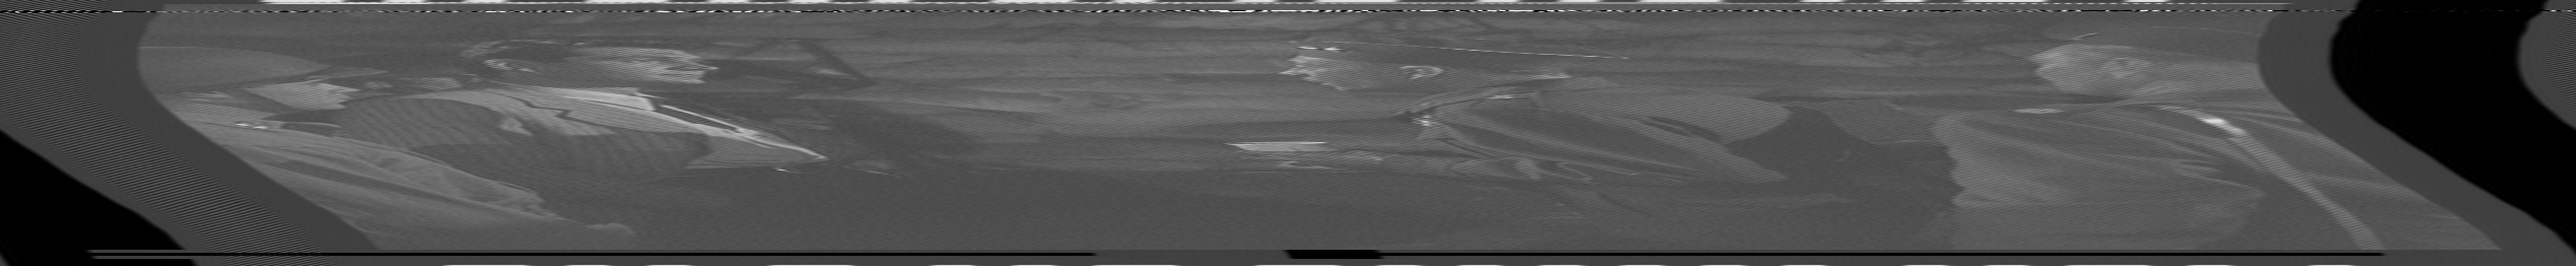

In [11]:
reduced = (demod[0]['demod'] - rfn.SysParams['ire0']) / rfn.SysParams['hz_ire']
reduced += 40
out_scale = 65534.0 / 160
foo = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

draw_raw_bwimage(foo, rfn.linelen, 262, hscale=2, vscale=2)

In [394]:
262*2542

666004

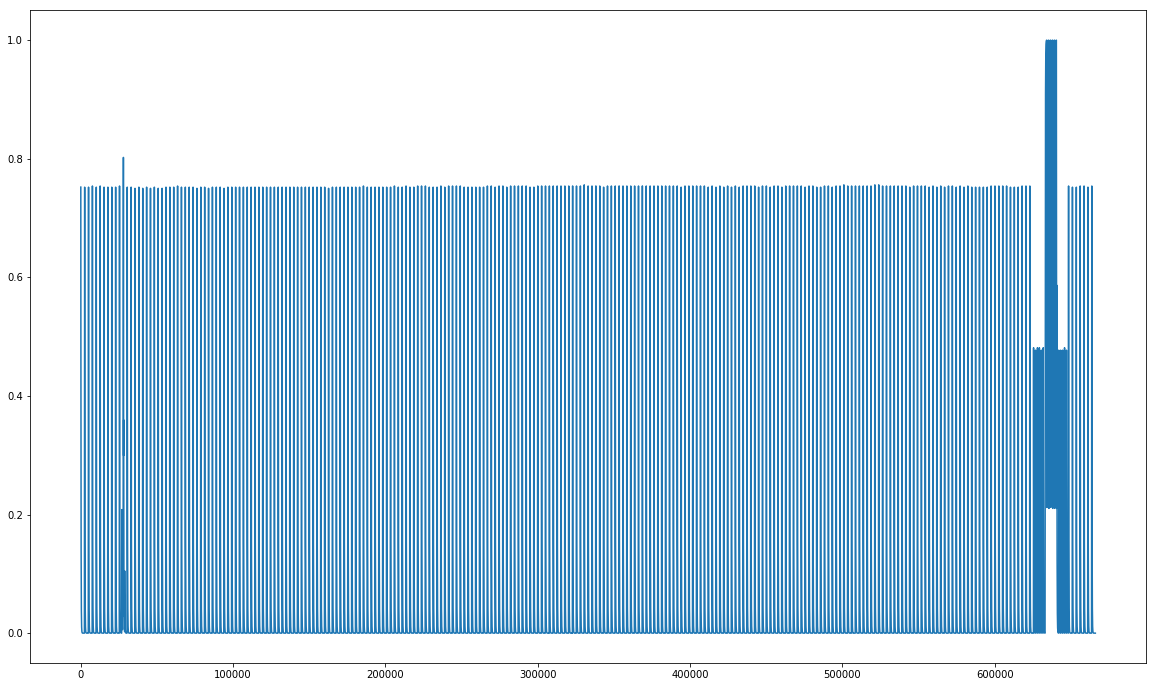

In [12]:
plt.plot(demod[0]['demod_sync'][0:666004])

In [118]:
1300000*50*30

1950000000

starting at  1048576000
[(226, 219, False)]
too short
invalid  1048576000 1049107829
[(17, 10, False), (288, 281, True)]
status code 9152512
False None
starting at  1049776701
[(17, 10, True), (287, 280, False)]
status code 9152512
True None
a
starting at  1050442509
[(17, 10, False), (288, 281, True)]
status code 9152512
False None
a
frame  610
1603
starting at  1051111374
[(17, 10, True), (287, 280, False)]
status code 9152512
True None
a
starting at  1051777172
[(17, 10, False), (288, 281, True)]
status code 9152512
False None
a
frame  611
1601
starting at  1052446043
[(17, 10, True), (287, 280, False)]
status code 9152512
True None
a
starting at  1053111851
[(17, 10, False), (288, 281, True)]
status code 9152512
False None
a
frame  612
1601
starting at  1053780714
[(17, 10, True), (287, 280, False)]
status code 9152512
True None
a
starting at  1054446517
[(17, 10, False), (288, 281, True)]
status code 9152512
False None
a
frame  613
1603
starting at  1055115387
[(17, 10, True), (28

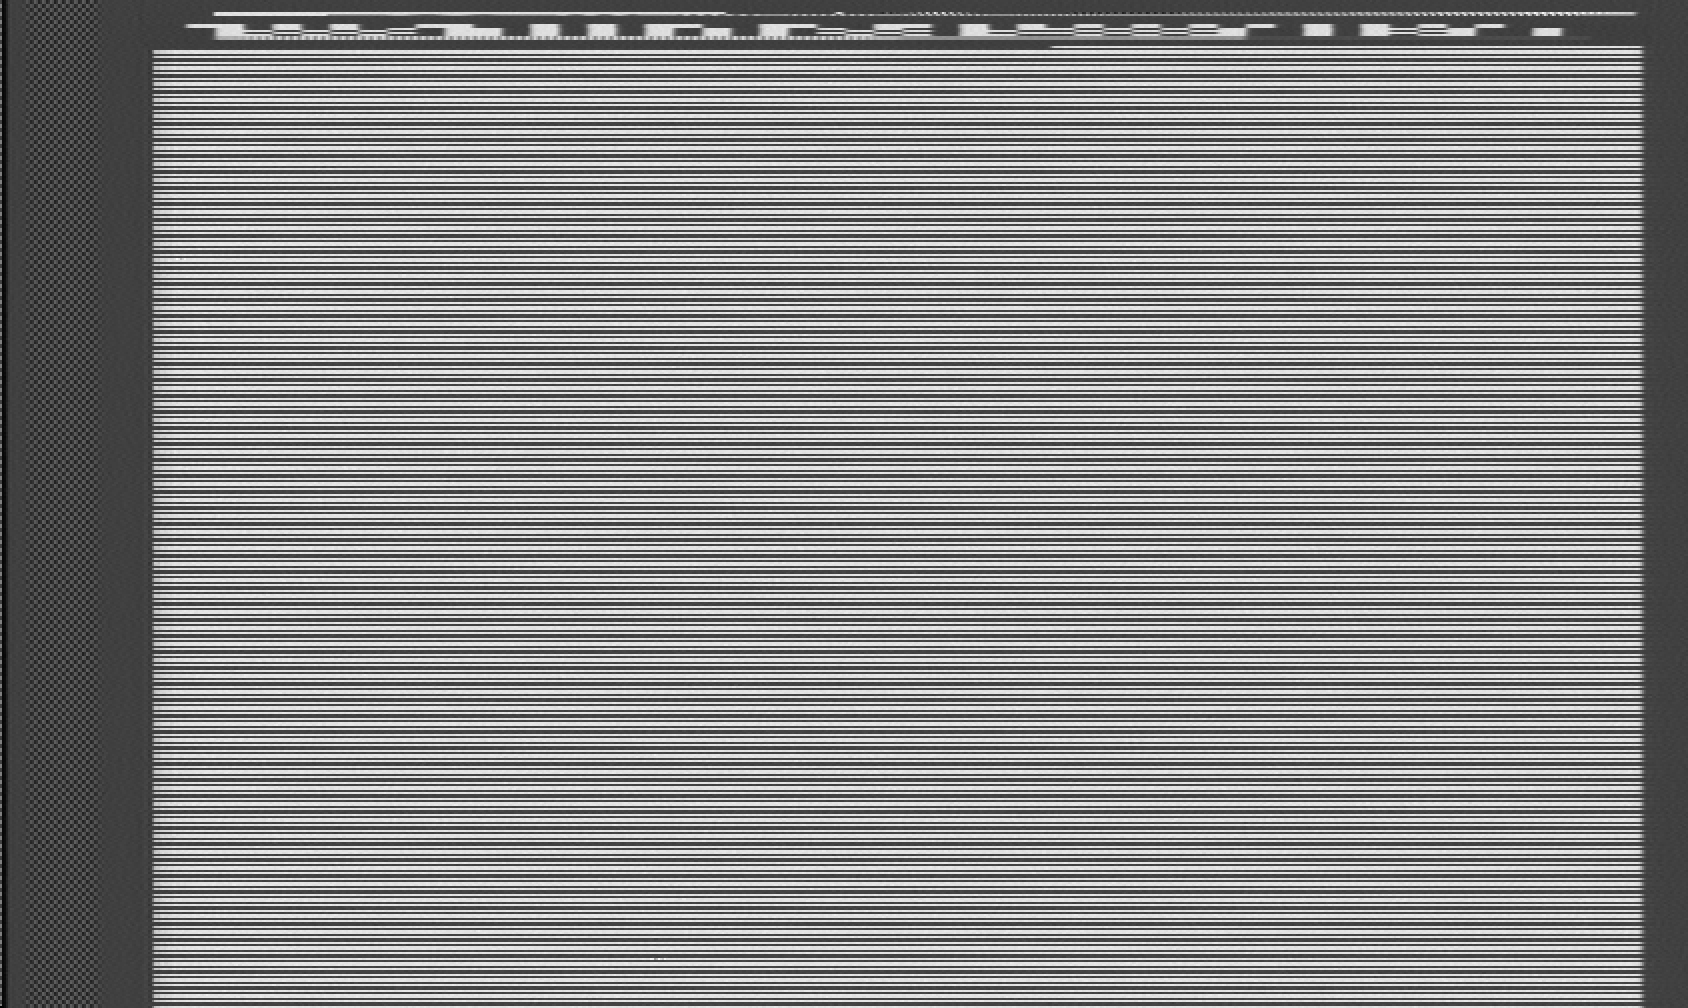

In [109]:
rfn = RFDecode(system='NTSC')

#infile = open('/mnt3/dd/War of the worlds_CAV_NTSC_side1_2018-10-03_06-24-34.lds', 'rb')
infile = open('/mnt3/ggv1069_side1_v2800_2018-09-28_07-33-31.lds', 'rb')
loader = load_packed_data_4_40

nextsample = 1024*1024*30000
nextsample = 1024*1024*1000
#nextsample = 2059514098
#nextsample = 70937831028

outfile = open('tmpntscb.tbc', 'wb')
outfile_audio = open('tmpntscb.pcm', 'wb')

framer_ntsc = Framer(rfn)
ca = []
for f in range(0,10):
    combined, audio, nextsample, fields = framer_ntsc.readframe(infile, nextsample, f == 0, CAV=False)
    
    print('frame ', framer_ntsc.vbi['framenr'])
    
    ca.append(audio)
    
    outfile.write(combined)
    print(len(audio)//2)
    outfile_audio.write(audio)

#draw_raw_bwimage(combined, outwidth, 610, hscale=2, vscale=2)

outfile.close()
outfile_audio.close()

draw_raw_bwimage(combined, 844, 504, hscale=2, vscale=2)

In [353]:
fields[0].vsyncs

[(12, 10, True), (253, 246, False)]

In [354]:
236*2

472

In [359]:
fields[0].peaklist[10], fields[0].peaklist[246]

(25416, 622999)

In [360]:
(622999-25416)/2542

235.0837922895358

In [65]:
rfn.linelen

2542

8 2560.279447343273
7 2560.033565830032
6 2559.926158456852
5 2560.291753848476
4 2559.858091199574
3 2560.100453002684
2 2559.2923161272374
1 2559.866500099517
0 2560.0616510046675
300 2560.421938032494
301 2559.7755646713777
302 2560.0402078838088
303 2559.993212555186
304 2559.1875308874296
305 2559.713469508337
306 2559.9189930759603
307 2559.219323997153
308 2559.7689998658607
309 2559.2730969836703
310 2559.47286219697
311 2558.9642606265843
312 2558.665667374269
313 2463.539802087471
314 2463.1576910784934
315 2461.7030180859147


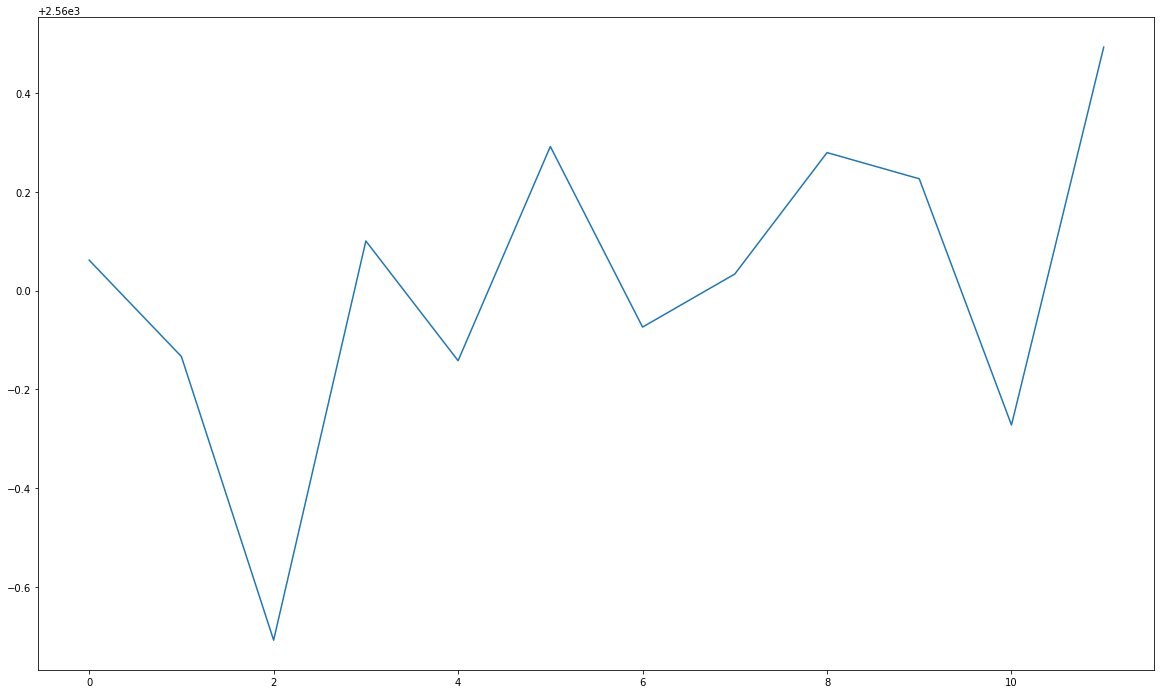

In [118]:
def Xrefine_linelocs_hsync(self):
    # Adjust line locations to end of HSYNC.
    # This causes issues for lines 1-9, where only the beginning is reliable :P

    offset = 32 

    err = [False] * len(self.linelocs[0])

    linelocs2 = self.linelocs[-1].copy()
    for i in range(len(self.linelocs[0])):
        # First adjust the lineloc before the beginning of hsync - 
        # lines 1-9 are half-lines which need a smaller offset
        if i > 9:
            linelocs2[i] -= offset
        else:
            linelocs2[i] -= 200 # search for *beginning* of hsync

        zc = calczc(self.data[0]['demod_05'], linelocs2[i], self.rf.iretohz(-20), reverse=False, _count=400)

        #print(i, linelocs2[i], zc)
        if zc is not None:
            linelocs2[i] = zc - 32

            origdata = self.data[0]['demod_05'][int(zc)-40:int(zc)+100]

            if np.min(origdata) < self.rf.iretohz(-50):
                err[i] = True

            if i >= 10: # don't run this second-stage adjustment code on vsync lines (yet?)
                # on some captures with high speed variation wow effects can mess up TBC.
                # determine the low and high values and recompute zc along the middle

                low = np.mean(origdata[0:20])
                high = np.mean(origdata[100:120])

                zc2 = calczc(origdata, 0, (low + high) / 2, reverse=False, _count=len(origdata))
                zc2 += (int(zc)-40)
                #print(i, low, high, zc, zc2)

                linelocs2[i] = zc2 - 32

                #(data[0]['demod'][int(zc)-100:int(zc)+20], rfd.iretohz(-50), rfd.iretohz(30)))
        else:
            err[i] = True

        if i < 10:
            pass
            linelocs2[i] += self.usectoinpx(4.72)
        elif err[i]: # and i >= 10
            gap = linelocs2[i - 1] - linelocs2[i - 2]
            linelocs2[i] = linelocs2[i - 1] + gap
            #print(i, zc, lbinelocs2[i])

    # XXX: HACK!
    # On both PAL and NTSC this gets it wrong for VSYNC areas.  They need to be *reasonably* 
    # accurate for analog audio, but are never seen in the picture.
    for i in range(8, -1, -1):
        gap = linelocs2[i + 1] - linelocs2[i]
        print(i, gap)
        if not inrange(gap, self.rf.linelen - (self.rf.freq * .2), self.rf.linelen + (self.rf.freq * .2)):
            gap = self.rf.linelen
            
        linelocs2[i] = linelocs2[i + 1] - gap

    # XXX2: more hack!  This one covers a bit at the end of a PAL field
    for i in range(300, len(linelocs2)):
        gap = linelocs2[i] - linelocs2[i - 1]
        print(i, gap)
        if not inrange(gap, self.rf.linelen - (self.rf.freq * .2), self.rf.linelen + (self.rf.freq * .2)):
            gap = self.rf.linelen
            
        linelocs2[i] = linelocs2[i - 1] + gap
        
        
    return linelocs2, err    

ll, err = Xrefine_linelocs_hsync(fields[0])

plt.plot(np.diff(ll[:13]))

In [117]:
np.diff(ll[311:])

array([2558.66566737, 2463.53980209, 2559.61788899, 2558.54532701])

(238420,)
uint8 (262, 910) (262, 910)


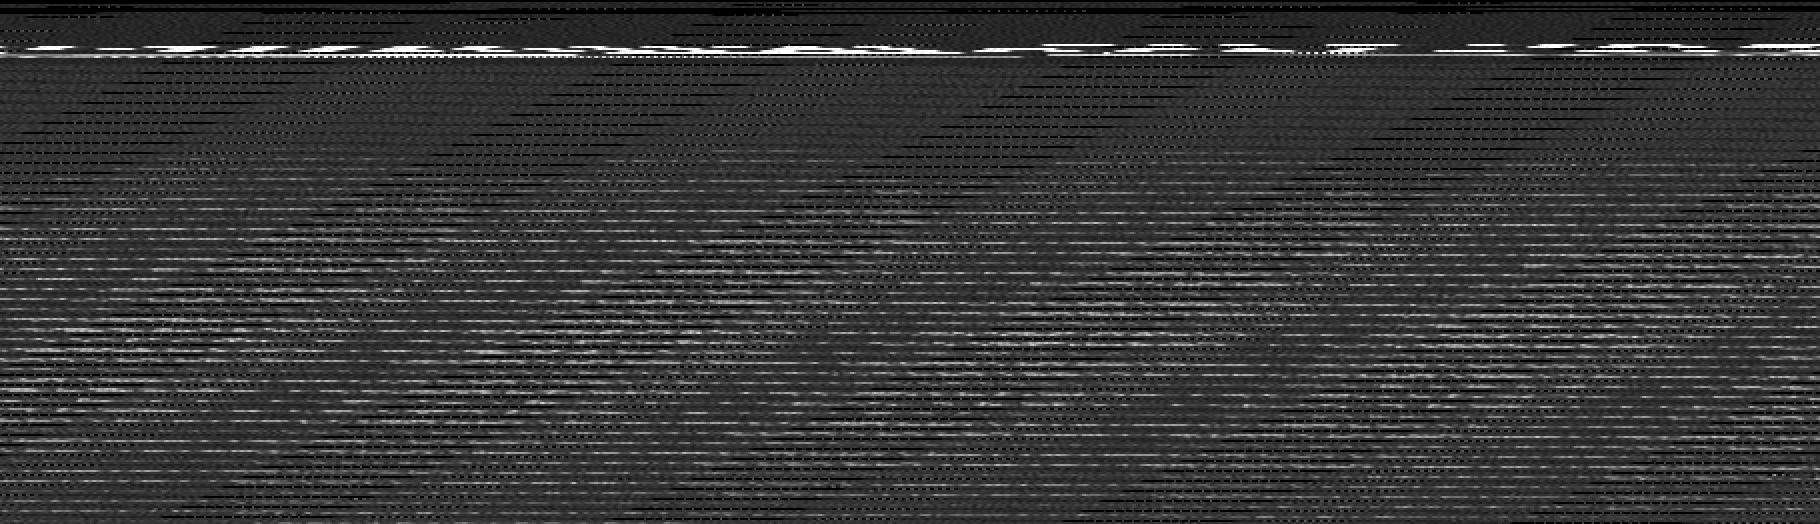

In [88]:
ds = fields[0].downscale(lineinfo = ll, final=True)[0]
draw_raw_bwimage(ds, 910, 262, hscale=2, vscale=2)

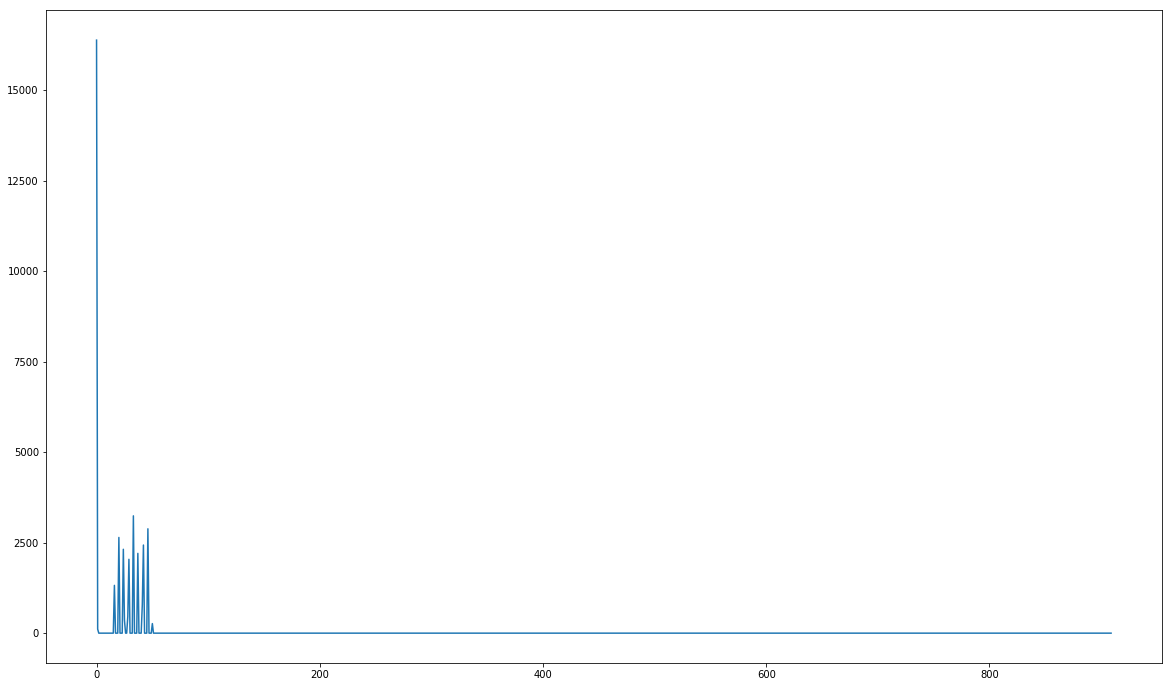

In [57]:
#plt.plot(ds[0*910:1*910])
#plt.plot(ds[1*910:2*910])
#plt.plot(ds[2*910:3*910])
plt.plot(ds[3*910:4*910])
plt.plot(ds[8*910:8*910])

In [346]:
fields[0].data[0]['demod']

array([8181288.18414862, 8204799.24631914, 8203351.94783468, ...,
       8336679.29164203, 8327366.32551333, 8322716.80950535])

(686340,)
uint8 (270, 2542) (270, 2542)


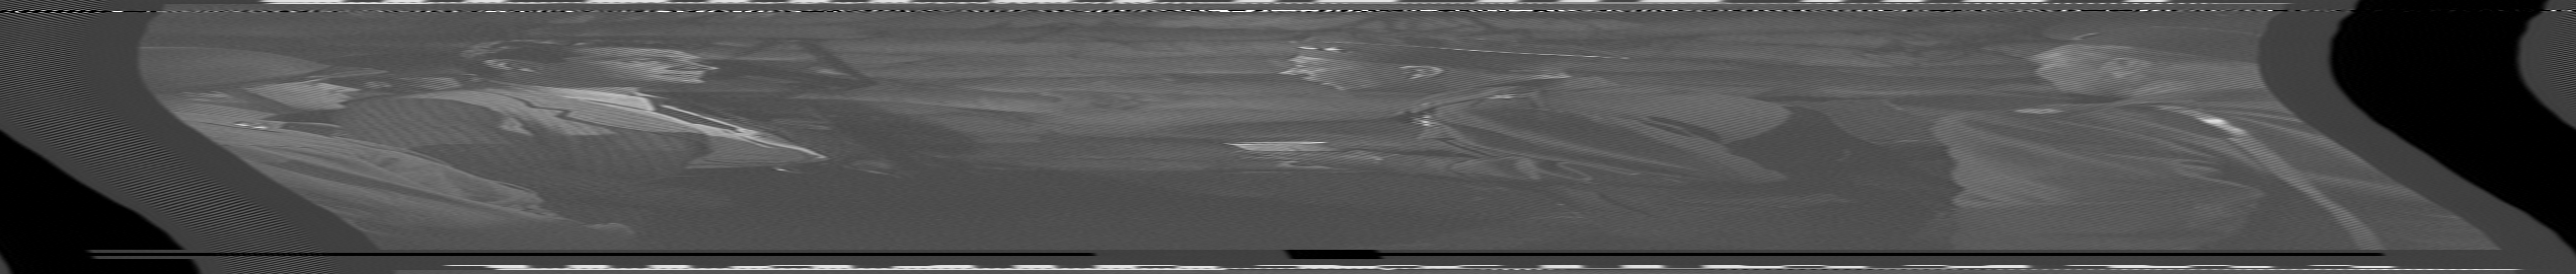

In [349]:
reduced = (fields[0].data[0]['demod'] - rfn.SysParams['ire0']) / rfn.SysParams['hz_ire']
reduced += 40
out_scale = 65534.0 / 160
foo = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

draw_raw_bwimage(foo, rfn.linelen, 270, hscale=2, vscale=2)

10 253


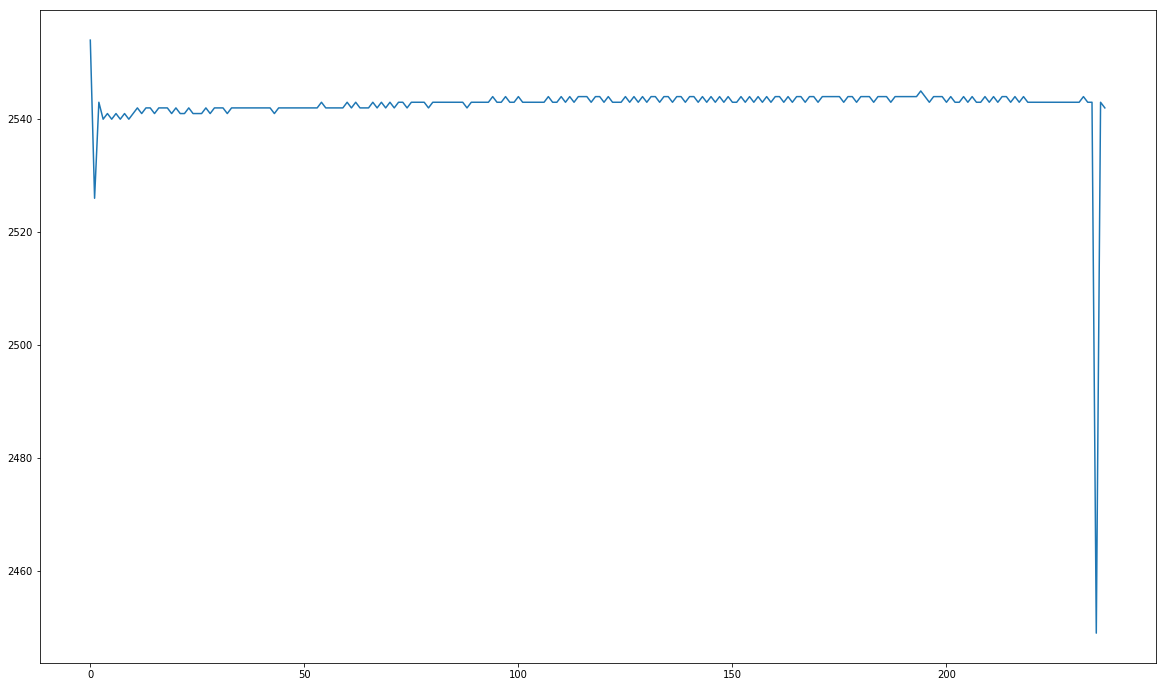

In [377]:
def Xcompute_linelocs(self):
    # Build actual line positions, skipping half-lines and adding padding as needed
    linelocs = [self.peaklist[self.vsyncs[0][1]]]

    print(self.vsyncs[0][1], self.vsyncs[1][0])
    
    for curindex in range(self.vsyncs[0][1] + 1, self.vsyncs[1][0]):
        curline = self.peaklist[curindex]
        #print(curline)

        # fill in as many missing lines as needed
        while (curline - linelocs[-1]) > (self.inlinelen * 1.95):
            linelocs.append(linelocs[-1] + (linelocs[-1] - linelocs[-2]))
        
        if (curline - linelocs[-1]) > (self.inlinelen * 1.05):
            print(len(linelocs), 'override', (curline - linelocs[-1]))
            linelocs.append(linelocs[-1] + self.inlinelen)
        elif (curline - linelocs[-1]) > (self.inlinelen * .95):
            linelocs.append(curline)

    return linelocs

xll = Xcompute_linelocs(fields[0])
xll = plt.plot(np.diff(xll))

In [ ]:
ds = fields[0].downscale(linelocs = final=True)[0]
draw_raw_bwimage(ds, 910, 262, hscale=2, vscale=2)

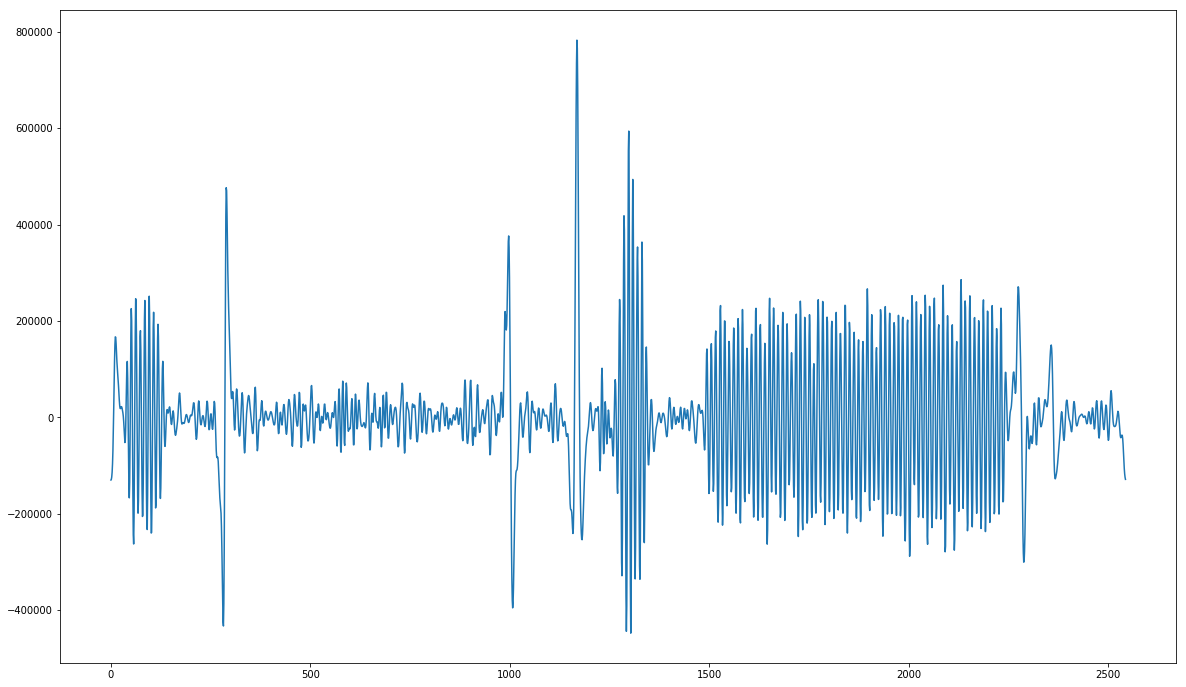

In [179]:
l = 20
f = 1

c = fields[f].linelocs[-1][l]
d = fields[f].linelocs[-1][l+1]
#plt.plot(fields[f].data[0]['demod_burst'][int(c):int(d)])
#plt.plot(fields[f].data[0]['demod_05'][int(c):int(d)])

shift = 32
e = fields[f].data[0]['demod'][int(c):int(d)] - fields[f].data[0]['demod_05'][int(c)+shift:int(d)+shift]
plt.plot(e)

#f = 1
#c = fields[f].linelocs[2][l]
#plt.plot(fields[f].data[0]['demod_05'][int(c - 50):int(c + 100)])

In [123]:
rf_pal = RFDecode(system='PAL')

infile_pal = open('/home/cpage/ddsftp/Domesday/Simon/LDV4300D_2 Captures/AIV/Domesday_DiscSet2/Domesday Community North_CAV_PAL_side1_Disc set 2_2018-10-02_15-11-01.lds', 'rb')
loader = load_packed_data_4_40

nextsample = 800800200

framer_pal = Framer(rf_pal)

outfile = open('tmppal.tbc', 'wb')
outfile_audio = open('tmppal.pcm', 'wb')

allaudio = []

for f in range(0,30):
    combined, audio, nextsample, fields = framer_pal.readframe(infile_pal, nextsample, f == 0)
    
    outfile.write(combined)
    outfile_audio.write(audio)
    allaudio.append(audio)

#draw_raw_bwimage(combined, outwidth, 610, hscale=2, vscale=2)

outfile.close()
outfile_audio.close()

PAL
starting at  800800200
[(306, 300, False)]
too short
invalid  800800200 801543640
[(16, 10, False), (335, 329, True)]
300 2559.2715490846895
301 2559.1283962558955
302 2559.592273438582
303 2559.3283445006236
304 2558.996520051034
305 2559.363127186778
306 2559.513847933151
307 2559.462461042218
308 2559.8167882469716
309 2559.389773222152
310 2559.7251351097366
311 2559.8898160749814
312 2559.7960402712924
313 2559.0562882747035
314 2464.353418450337
315 2464.1998045693617
status code 9151519
False None
starting at  802344136
[(16, 10, True), (335, 329, False)]
300 2560.421938032494
301 2559.7755646713777
302 2560.0402078838088
303 2559.993212555186
304 2559.1875308874296
305 2559.713469508337
306 2559.9189930759603
307 2559.219323997153
308 2559.7689998658607
309 2559.2730969836703
310 2559.47286219697
311 2558.9642606265843
312 2558.665667374269
313 2463.539802087471
314 2463.1576910784934
315 2461.7030180859147
True None
a
starting at  803143638
[(16, 10, False), (335, 329, Tru

False None
a
starting at  816744066
[(16, 10, True), (335, 329, False)]
300 2560.8662831856636
301 2560.7083938675933
302 2561.0522076676134
303 2560.841438125237
304 2560.492357465322
305 2561.0538502873387
306 2560.206916932948
307 2560.0222430682043
308 2560.958741404931
309 2560.5800237768563
310 2559.985601345892
311 2560.31269538193
312 2560.6131939471234
313 2464.004683579318
314 2463.9726176657714
315 2464.1887539215386
True None
a
starting at  817543607
[(16, 10, False), (335, 329, True)]
300 2559.5708120237105
301 2559.466250303667
302 2559.2205603653565
303 2559.7783909335267
304 2559.5578242881456
305 2559.363701593131
306 2559.116735419724
307 2560.546670700307
308 2559.691352186259
309 2559.627362352796
310 2559.0574892504374
311 2559.9086682820925
312 2559.8729114199523
313 2559.436629629461
314 2464.29187477543
315 2463.8225393616594
status code 9151519
False None
a
starting at  818344090
[(16, 10, True), (335, 329, False)]
300 2561.135020797956
301 2560.3042878914857
3

True None
a
starting at  831943519
[(16, 10, False), (335, 329, True)]
300 2559.168436723994
301 2559.4448008319596
302 2559.4498336265096
303 2559.76361354196
304 2559.2458990457235
305 2559.2667989761103
306 2559.52824515698
307 2560.124006735976
308 2559.622345904121
309 2559.5065965425456
310 2559.650810277206
311 2559.944862992037
312 2559.945212388411
313 2559.513248932082
314 2463.8263600145
315 2464.1353519766126
status code 9151519
False None
a
starting at  832743999
[(16, 10, True), (335, 329, False)]
300 2560.464732933091
301 2561.0411263322458
302 2560.111719225184
303 2560.3339190912666
304 2560.971458701999
305 2560.941415969981
306 2559.9862728454173
307 2560.545381846954
308 2560.566686363076
309 2560.1720162770944
310 2559.9214847621042
311 2560.190767946653
312 2559.7009275893215
313 2464.59400663455
314 2464.31288567069
315 2464.382486377959
True None
a
starting at  833543553
[(16, 10, False), (335, 329, True)]
300 2559.3686401485465
301 2558.431094661588
302 2559.34

False None
a
starting at  847143978
[(16, 10, True), (335, 329, False)]
300 2560.6248362275073
301 2560.833318473422
302 2560.2006977656856
303 2560.91058054287
304 2560.1883022417314
305 2560.460763629875
306 2560.7086955392733
307 2560.2687294043135
308 2560.2475681218784
309 2560.711079322151
310 2559.991255980567
311 2560.0386195282917
312 2560.252566276933
313 2464.44602528261
314 2465.121943563223
315 2464.8749404002447
True None
a
starting at  847943469
[(16, 10, False), (335, 329, True)]
300 2559.0438225514954
301 2559.9787766751833
302 2559.1264536851086
303 2559.126204014756
304 2559.393008377636
305 2559.78330970183
306 2559.310241216561
307 2559.6103522104677
308 2559.6990426417906
309 2559.384531785501
310 2560.0248154453
311 2559.1297761640744
312 2559.7672767355107
313 2559.7971376260975
314 2463.901476163417
315 2464.0427779586753
status code 9151519
False None
a
starting at  848743965
[(16, 10, True), (335, 329, False)]
300 2559.8958807629533
301 2560.015848575742
302 

(641720,)
uint8 (610, 1052) (610, 1052)


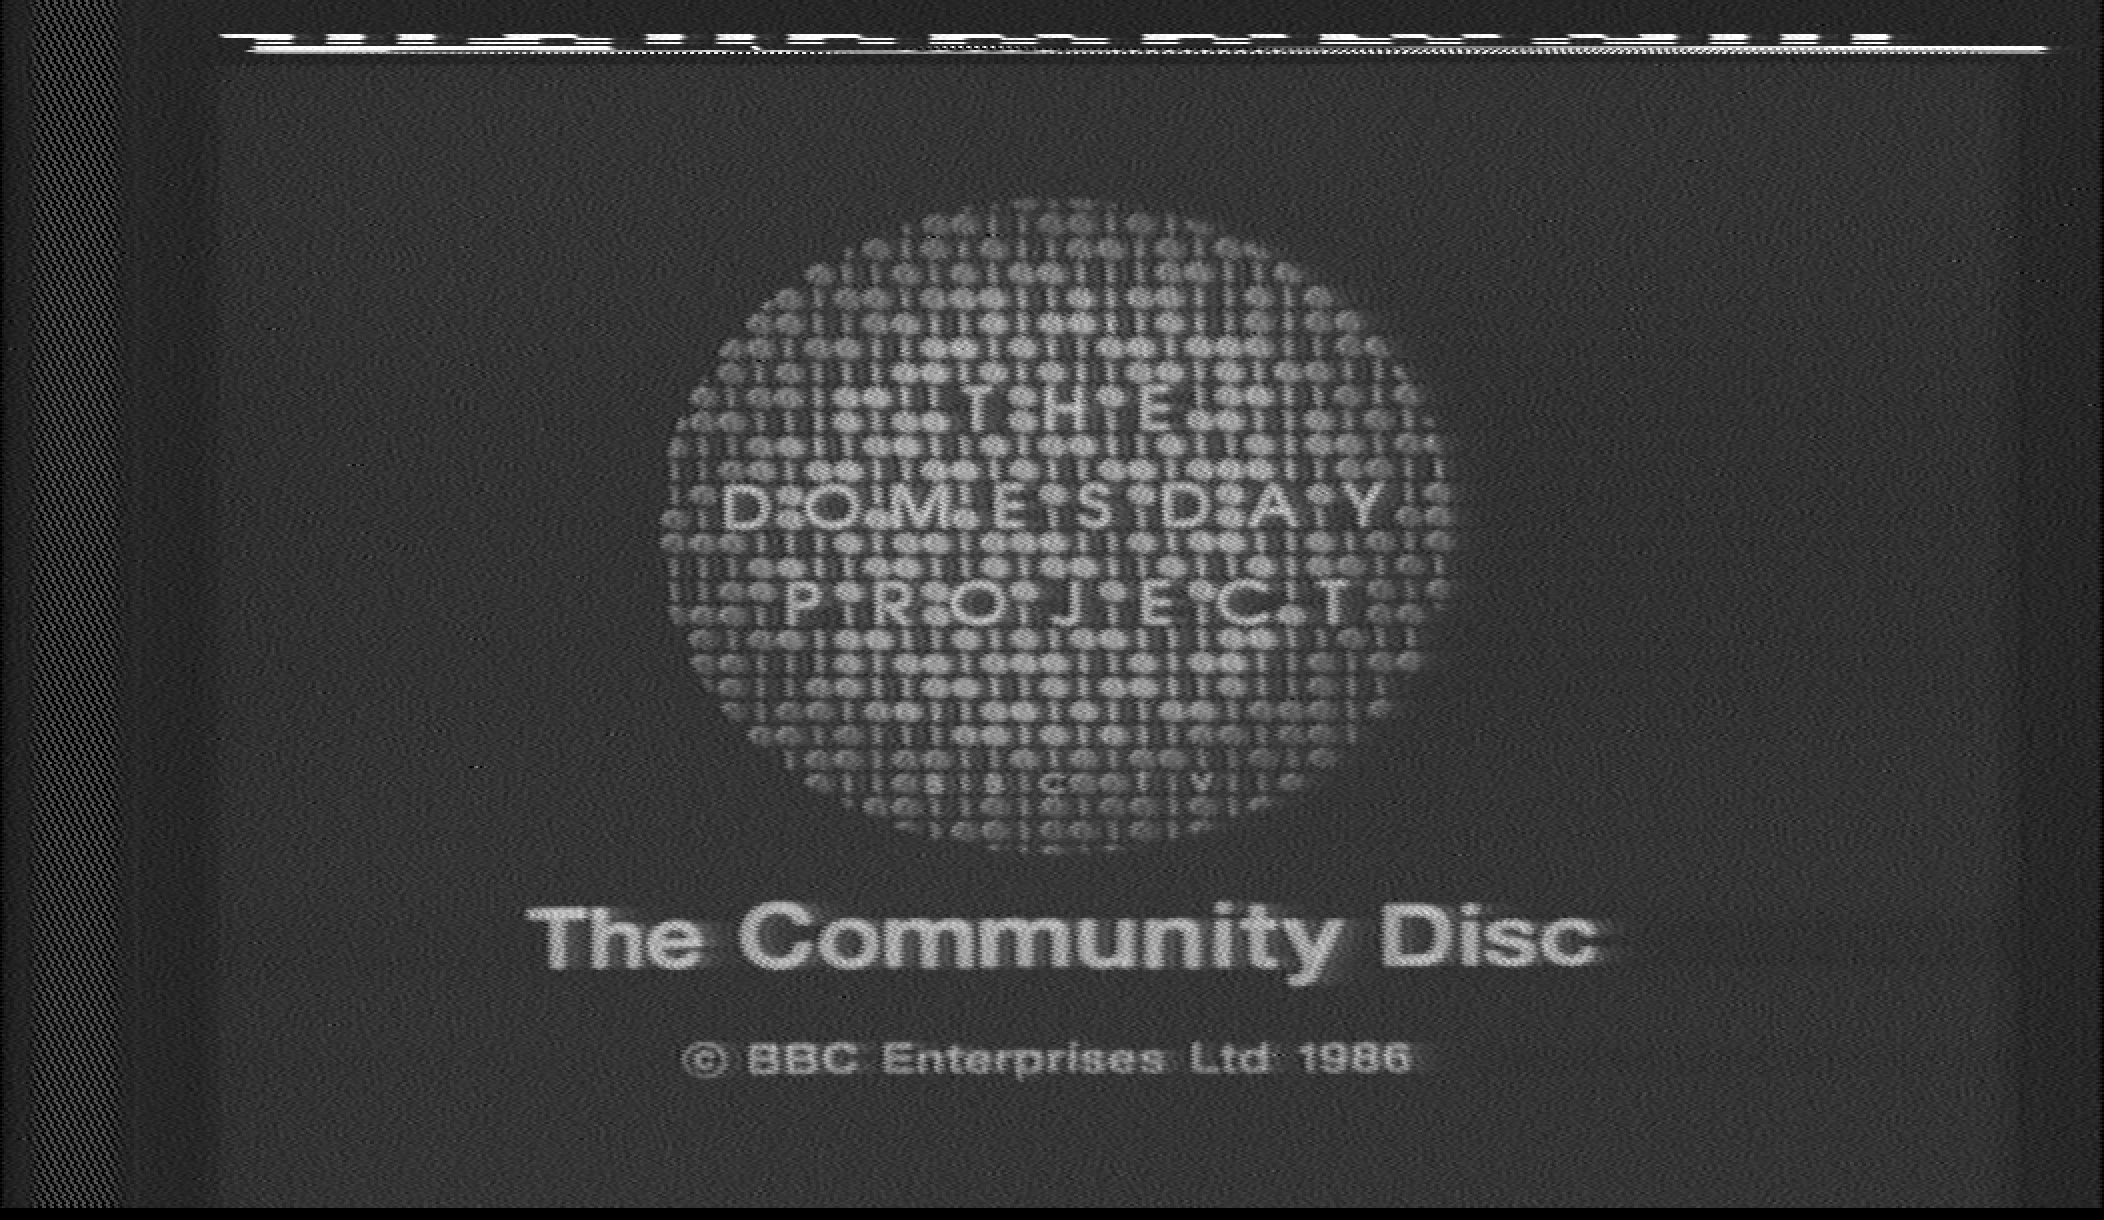

In [97]:
draw_raw_bwimage(combined, 1052, 610, hscale=2, vscale=2)

In [107]:
a = np.concatenate(allaudio)

In [103]:
len(allaudio[1])

3842

In [105]:
1921*25

48025

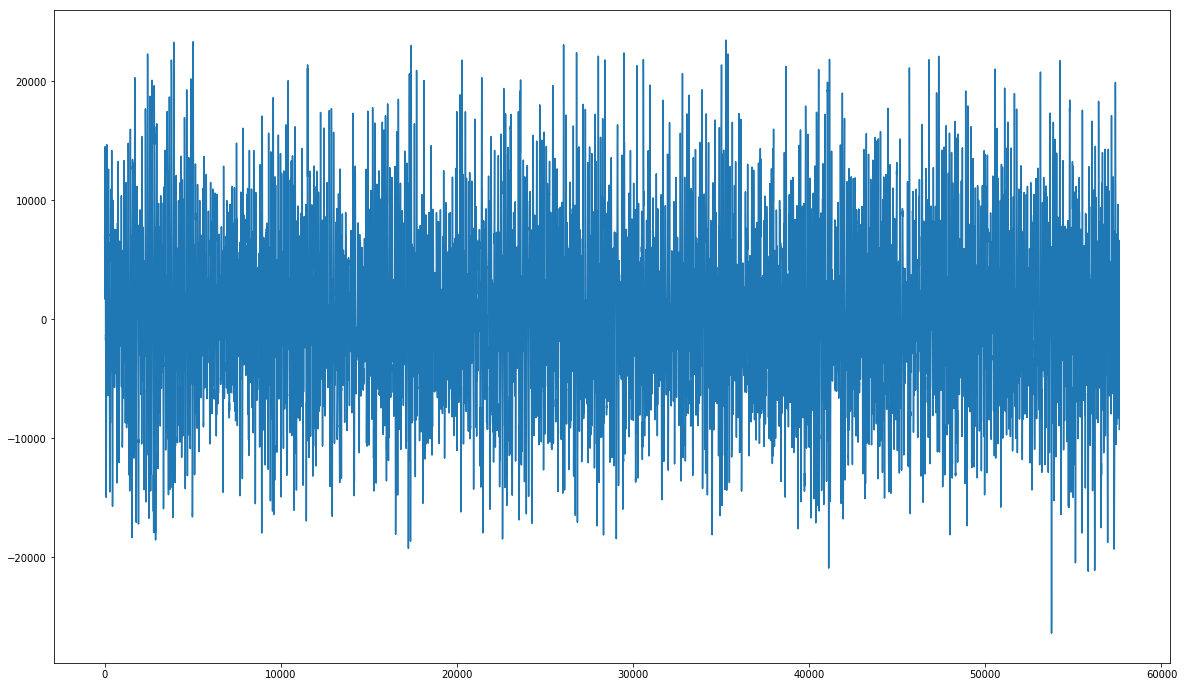

In [108]:
plt.plot(a[1::2])

In [157]:
len(audio)//4

960